In [1]:
import torch
import torch.nn as nn

import numpy as np
from torchtext import datasets
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split
import portalocker

In [2]:
print(torch.version.cuda)
print(torch.__version__)

12.1
2.2.0+cu121


In [3]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

DEVICE = torch.device('cuda')
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [4]:
tokenizer = get_tokenizer("basic_english")

# Pre-process

**Dataset**

1: Neg

2: Pos

In [5]:
train_data = datasets.IMDB('./data', split='train') 
test_data = datasets.IMDB('./data', split='test')

targets = []
for x in train_data:
    targets.append(x[0])

print(len(targets))
print(np.unique(targets, return_counts=True))

25000
(array([1, 2]), array([12500, 12500], dtype=int64))


Change the label to

0: pos <br>
1: neg

In [6]:
import random

train = [(1, x[1]) if x[0] == 1 else (0, x[1]) for x in train_data]
test = [(1, x[1]) if x[0] == 1 else (0, x[1]) for x in test_data]


random.shuffle(train)
random.shuffle(test)

######

temp = train[:7000]
train, val = temp[:6000], temp[6000:]

temp = test[:3000]



In [7]:
for i, line in enumerate(train):
    if i > 10:
        break
    print(line)

(0, "#3 in young John Travolta's trilogy of blockbusters. He dances to disco, rock 'n' roll and country. He heads to Houston to find work and love. Gilley's is the hot spot, and it is the time of the mechanical bull. Not to be outdone, I rode the bull at a club in Nashville. I recently saw this nearly forgotten film on television and remembered how good it was and how good a year 1980 was. I wore a black cowboy hat that year just like Travolta. Debra Winger was in her prime. She looks stunning in her red top. There is plenty of charisma. Bud and Sissy seem the ideal couple even if they are trailer trash. They split up just because it feels so good getting back together. Urban Cowboy has an amazing soundtrack. We get to hear Lyin' Eyes by The Eagles and Lookin' For Love by Johnny Lee.")
(0, "This is a great movie from the lost age of reactionary made-for-television drama. My all-time favourite actor, Robert Culp skillfully plots a trajectory through uptight liberal fairmindedness and fa

Glove pre-trained vector with embedding dimensions

In [8]:
glove = GloVe(name='6B', dim=100)

Add a Padding tokken to stoi

In [9]:
if '<PAD>' not in glove.stoi:
  glove.itos.append('<PAD>')

  # Add a corresponding zero vector to the embeddings
  glove.vectors = torch.cat([glove.vectors, torch.zeros((1, glove.dim))])

  # Update the 'stoi' dictionary
  glove.stoi = {token: i for i, token in enumerate(glove.itos)}

In [10]:
glove.stoi['<PAD>']

400000

# VanillaRNN

In [11]:
class VanillaRNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):

      super(VanillaRNN, self).__init__()

      self.emb = nn.Embedding.from_pretrained(glove.vectors)
      self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='tanh')
      self.fc = nn.Linear(hidden_size, num_classes)
      self.hidden_size = hidden_size

    def forward(self, x):

      h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

      x = self.emb(x)
      out, _ = self.rnn(x, h0)
      out = self.fc(out[:, -1, :])

      return out


# LSTM

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size

        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.emb(x)

        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])

        return out


# Evaluation

![link text](https://i.stack.imgur.com/iSQ7j.png)

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
import string

def clean_data(input_string):
    # matching all punctuation
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    result = regex.sub('', input_string)

    # Remove all special characters
    result = re.sub('[^A-Za-z0-9 ]+', '', result)

    # Remove HTML tags
    result = re.sub('<.*?>', '', result)

    # Remove stopwords
    result = result.split()
    stop_words = set(stopwords.words('english'))
    result = [word for word in result if word not in stop_words]

    # concatenate
    result = ' '.join(result)

    return result


# set a max length for faster training
def collate_batch(batch, max_length = 50):
    labels, texts = zip(*batch)

    text_data = []

    for text in texts:
        vic_id = []
        clean = clean_data(text)

        for token in tokenizer(clean):
            if token in glove.stoi:
                vic_id.append(glove.stoi[token])

        text_data.append(torch.tensor(vic_id).clone().detach().to(DEVICE))

    if max_length != -1:
      text_data = [text[:max_length] for text in text_data]

    #Pad sequences
    text_data = pad_sequence(text_data, batch_first=True, padding_value=(len(glove)-1))
    

    return text_data, torch.tensor(labels).clone().detach()


# Define DataLoader for training and testing

train_iterator = DataLoader(train, batch_size=256, collate_fn=collate_batch)
test_iterator = DataLoader(test, batch_size=256, collate_fn=collate_batch)
val_iterator = DataLoader(val, batch_size = 256, collate_fn=collate_batch)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Training and testing

In [14]:
import matplotlib.pyplot as plt

def evaluate(model, iterator):

    total_correct = 0
    total_count = 0

    for text, labels in iterator:

      text = text.to(DEVICE)
      labels = labels.to(DEVICE)

      output = model(text)

      pred = output.max(1, keepdim=True)[1]

      total_correct += pred.eq(labels.view_as(pred)).sum().item()
      total_count += labels.shape[0]

    return total_correct / total_count


# Training and testing
def train_test(model):

  N_EPOCHS = 10

  losses_train = []
  accuracy_train = []

  losses_val = []
  accuracy_val = [] 
  
  optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)

  criterion = nn.CrossEntropyLoss()

  for epoch in range(N_EPOCHS):

    # Training loop
    for text, labels in train_iterator:

      text = text.to(DEVICE)
      labels = labels.to(DEVICE)

      optimizer.zero_grad()

      predictions = model(text)

      loss = criterion(predictions, labels)

      loss.backward()

      optimizer.step()


      losses_train.append(float(loss))
      acc = evaluate(model, train_iterator)
      accuracy_train.append(acc)

    with torch.no_grad():
      for text, labels in val_iterator:

        text = text.to(DEVICE)
        labels = labels.to(DEVICE)

        predictions = model(text)

        loss = criterion(predictions, labels)

        losses_val.append(float(loss))
        acc = evaluate(model, val_iterator)
        accuracy_val.append(acc)


    
    print("Epoch %d; Training Loss %f; Train Acc %f" % (epoch+1, loss, acc))


  plt.title("Training Loss Curve")
  plt.plot(losses_train, label="Train")
  plt.plot(losses_val, label="Validation")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Training Acc Curve")
  plt.plot(accuracy_train, label="Train")
  plt.plot(accuracy_val, label="Validation")
  plt.xlabel("Iteration")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  acc_test = evaluate(model, test_iterator)

  print("Test Acc %f" % (acc_test))


## Train models

**VanillaRNN**

In [15]:
hidden_size = 50

Epoch 1; Training Loss 0.690545; Train Acc 0.528000
Epoch 2; Training Loss 0.689655; Train Acc 0.546000
Epoch 3; Training Loss 0.688021; Train Acc 0.565000
Epoch 4; Training Loss 0.640817; Train Acc 0.638000
Epoch 5; Training Loss 0.640714; Train Acc 0.659000
Epoch 6; Training Loss 0.625124; Train Acc 0.682000
Epoch 7; Training Loss 0.608283; Train Acc 0.679000
Epoch 8; Training Loss 0.603580; Train Acc 0.694000
Epoch 9; Training Loss 0.595356; Train Acc 0.694000
Epoch 10; Training Loss 0.589645; Train Acc 0.710000


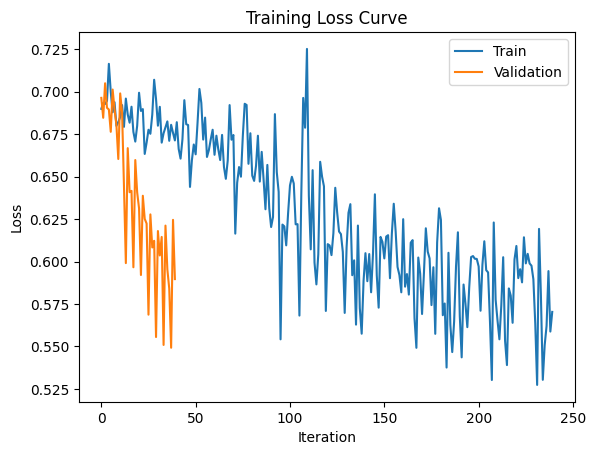

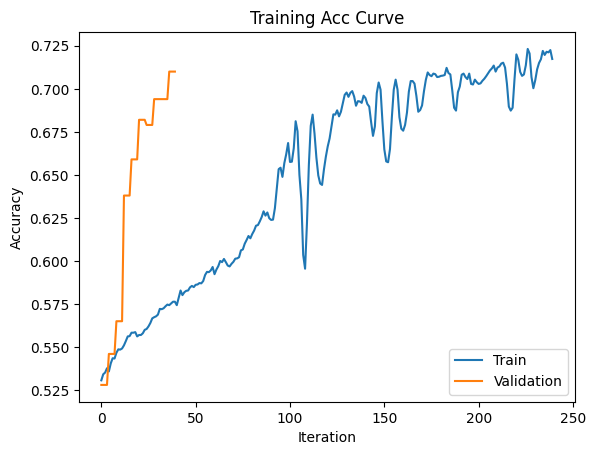

Test Acc 0.689000


In [16]:
van_rnn = VanillaRNN(glove.vectors.shape[1], hidden_size, 2)

van_rnn = van_rnn.to(DEVICE)

train_test(van_rnn) 

**LSTM**

Epoch 1; Training Loss 0.691110; Train Acc 0.541000
Epoch 2; Training Loss 0.685511; Train Acc 0.590000
Epoch 3; Training Loss 0.628421; Train Acc 0.675000
Epoch 4; Training Loss 0.608964; Train Acc 0.716000
Epoch 5; Training Loss 0.587573; Train Acc 0.689000
Epoch 6; Training Loss 0.571748; Train Acc 0.709000
Epoch 7; Training Loss 0.561577; Train Acc 0.713000
Epoch 8; Training Loss 0.561621; Train Acc 0.707000
Epoch 9; Training Loss 0.562647; Train Acc 0.714000
Epoch 10; Training Loss 0.557869; Train Acc 0.712000


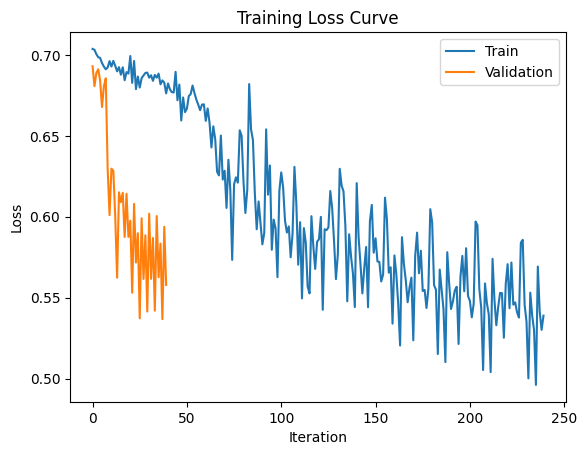

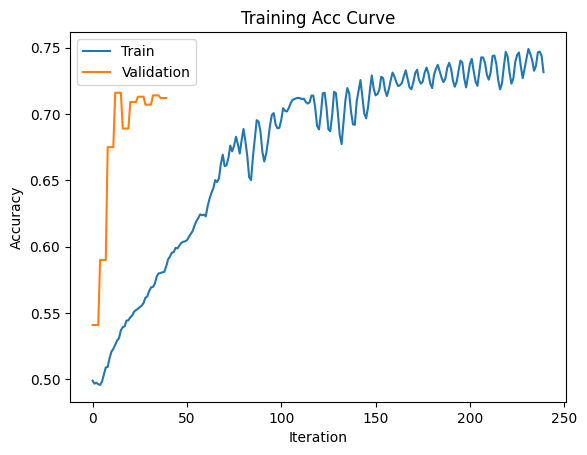

Test Acc 0.702600


In [17]:
lstm = LSTMModel(glove.vectors.shape[1], hidden_size, 2)
lstm = lstm.to(DEVICE)
train_test(lstm)

**Random test**

In [18]:
review_pos = "I recently had the pleasure of watching this film, and I must say, it was an absolute delight from start to finish. The storyline was captivating, filled with unexpected twists and turns that kept me on the edge of my seat."
review_neg = "I had high expectations for this film, but unfortunately, it fell short in many areas. The plot was predictable and lacked originality. It seemed as though the writers had taken elements from various successful films and tried to combine them, but the result was a disjointed narrative that failed to engage."
review_neg_2 = "In the grand orchestra of film-making, every element must play in harmony to create a beautiful symphony. Regrettably, this film was more of a cacophony than a symphony. The narrative, the supposed conductor of this orchestra, was found wanting. It was as predictable as a metronome, lacking the originality and creativity that one expects from a maestro. It was as if the script was a medley of overplayed tunes, leaving the audience yearning for a fresh melody.The performances, the instrumentalists of this ensemble, were sadly off-key. The actors seemed to be playing from different scores, resulting in a performance that was disjointed and out of sync. The dialogue, the music of this piece, was trite and uninspired, turning what should have been a powerful crescendo into a feeble pianissimo. The pacing, the rhythm of this composition, was erratic. The film meandered like a rudderless ship, lost in the vast ocean of its plot. Important moments were rushed, while trivial scenes were drawn out like a slow, monotonous drone. The cinematography and special effects, the only redeeming features, were like a virtuoso playing to an empty hall. They were unable to salvage the performance from its uninspiring score and lackluster execution."

In [19]:
test_p, test_l = collate_batch(((0, review_pos), (1,review_neg ), (1, review_neg_2)), max_length = -1)
test_l

tensor([0, 1, 1])

In [20]:
test_p = test_p.to(DEVICE)
out_van = van_rnn(test_p)
out_van.max(1, keepdim=True)[1]

tensor([[0],
        [1],
        [1]], device='cuda:0')

In [21]:
out_lstm = lstm(test_p)
out_lstm.max(1, keepdim=True)[1]

tensor([[0],
        [0],
        [0]], device='cuda:0')

# Reference

1. https://www.cs.toronto.edu/~lczhang/321/lec/rnn_notes.html

2. https://www.youtube.com/watch?v=KgrdifrlDxg

3. https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L15/2_packed-lstm.ipynb

4. https://stackoverflow.com/questions/56856236/pytorch-how-to-achieve-higher-accuracy-with-imdb-review-dataset-using-lstm

5. https://stackoverflow.com/questions/60196755/why-is-very-simple-pytorch-lstm-model-not-learning